# **Pneumonia Detection using Convolutional Neural Network**

## **image classification by matching CSV and raw images**

In [ ]:
import os
import pandas as pd
import shutil

# Paths
CSV_PATH = r"Data_Entry_2017_v2020.csv"
IMAGES_PATH = r"images_001/images"

# Read CSV file
df = pd.read_csv(CSV_PATH)

# Check if the required columns exist
if "Image Index" not in df.columns or "Finding Labels" not in df.columns:
    raise ValueError("❌ Required columns not found in the CSV file!")

# Create output folders
NORMAL_PATH = os.path.join(IMAGES_PATH, "NORMAL")
PNEUMONIA_PATH = os.path.join(IMAGES_PATH, "PNEUMONIA")
os.makedirs(NORMAL_PATH, exist_ok=True)
os.makedirs(PNEUMONIA_PATH, exist_ok=True)

# Move images based on classification
for _, row in df.iterrows():
    image_name = row["Image Index"]
    label = row["Finding Labels"]

    # Determine class
    if label == "No Finding":
        dest_folder = NORMAL_PATH
    else:
        dest_folder = PNEUMONIA_PATH

    # Source and destination paths
    src_path = os.path.join(IMAGES_PATH, image_name)
    dest_path = os.path.join(dest_folder, image_name)

    # Move file if it exists
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
    else:
        print(f"⚠️ Warning: {image_name} not found in dataset!")

print("✅ Image classification completed successfully!")

# **Preprocessing the dataset**

In [1]:
import os
import cv2
import numpy as np
from skimage import exposure
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf

# Define paths
DATASET_PATH = "images_001/images"
OUTPUT_PATH = "images_001/preprocessed_dataset"
IMAGE_SIZE = (224, 224)  # Resize to a uniform shape

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

def preprocess_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Skipping corrupt image: {image_path}")
            return None

        # 1️⃣ Resize
        img = cv2.resize(img, IMAGE_SIZE)
        
        # 2️⃣ Convert to Grayscale (if not already grayscale)
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        
        # 3️⃣ Noise Reduction (Gaussian Blur)
        denoised = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # 4️⃣ Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        
        return enhanced  # Only returning the enhanced version to save space
    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")
        return None

# Function to process and save images
def process_and_save(label, filename):
    img_path = os.path.join(DATASET_PATH, label, filename)
    processed_image = preprocess_image(img_path)
    if processed_image is None:
        return
    
    output_folder = os.path.join(OUTPUT_PATH, label)
    os.makedirs(output_folder, exist_ok=True)
    
    save_path = os.path.join(output_folder, filename)  # Save with original filename
    cv2.imwrite(save_path, processed_image)  # Save only enhanced version

# Process all images using multithreading
for label in ["NORMAL", "PNEUMONIA"]:
    input_folder = os.path.join(DATASET_PATH, label)
    filenames = os.listdir(input_folder)
    
    with ThreadPoolExecutor(max_workers=8) as executor:
        executor.map(lambda fname: process_and_save(label, fname), filenames)

print("🎯 Image Preprocessing Completed!")

🎯 Image Preprocessing Completed!


# **Spliting the dataset** <br>
**Train data:** 80%<br>
**Test data:** 10%<br>
**Validation data:** 10%

In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define paths
DATASET_PATH = r"images_001/preprocessed_dataset"
OUTPUT_PATH = r"images_001\split_data"  # New directory for split dataset

# Categories (folder names)
categories = ["NORMAL", "PNEUMONIA"]

# Create train, val, test directories
for split in ["train", "val", "test"]:
    for category in categories:
        os.makedirs(os.path.join(OUTPUT_PATH, split, category), exist_ok=True)

# Load image file paths and labels
image_paths = []
labels = []

for category in categories:
    folder_path = os.path.join(DATASET_PATH, category)
    for filename in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, filename))
        labels.append(category)  # Assign category label

# Convert to NumPy arrays (optional, for safety)
image_paths = np.array(image_paths)
labels = np.array(labels)

# 1️⃣ Split into Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# 2️⃣ Split Temp into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Function to move images to respective folders
def move_files(image_list, label_list, split):
    for img_path, label in zip(image_list, label_list):
        filename = os.path.basename(img_path)
        destination = os.path.join(OUTPUT_PATH, split, label, filename)
        shutil.copy(img_path, destination)  # Copy image to new location

# Move images to train, val, and test directories
move_files(X_train, y_train, "train")
move_files(X_val, y_val, "val")
move_files(X_test, y_test, "test")

print("✅ Dataset successfully split into Train, Validation, and Test sets!")

✅ Dataset successfully split into Train, Validation, and Test sets!


In [11]:
pip install numpy matplotlib opencv-python keras tensorflow keras-preprocessing

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
   ---------------------------------------- 0.0/42.6 kB ? eta -:--:--
   ---------------------------- ----------- 30.7/42.6 kB ? eta -:--:--
   ---------------------------- ----------- 30.7/42.6 kB ? eta -:--:--
   ---------------------------------------- 42.6/42.6 kB 296.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# **Libraries Used**<br>
* Tensorflow
* Numpy
* keras
* opencv python
* matplotlib
* keras preprocessing

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import cv2

**Creating a train data generator**

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

**Storing the train data inside train_images (every image size is 224x224)**<br>
Every image will be resized to 300x300

In [9]:
train_images = "images_001/split_data/train"

In [11]:
train_generator = train_datagen.flow_from_directory(train_images,
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary')

Found 4672 images belonging to 2 classes.


**Model Outputs**
<br>
0 : Normal condition
<br>
1 : Pneumonia condition

In [13]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

**Validation data generator and loading validation data**

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory('images_001/split_data/val',
    target_size= (300,300),
    batch_size = 128,
    class_mode = 'binary')

Found 584 images belonging to 2 classes.


**Plotting the images with neumonia from the dataset**

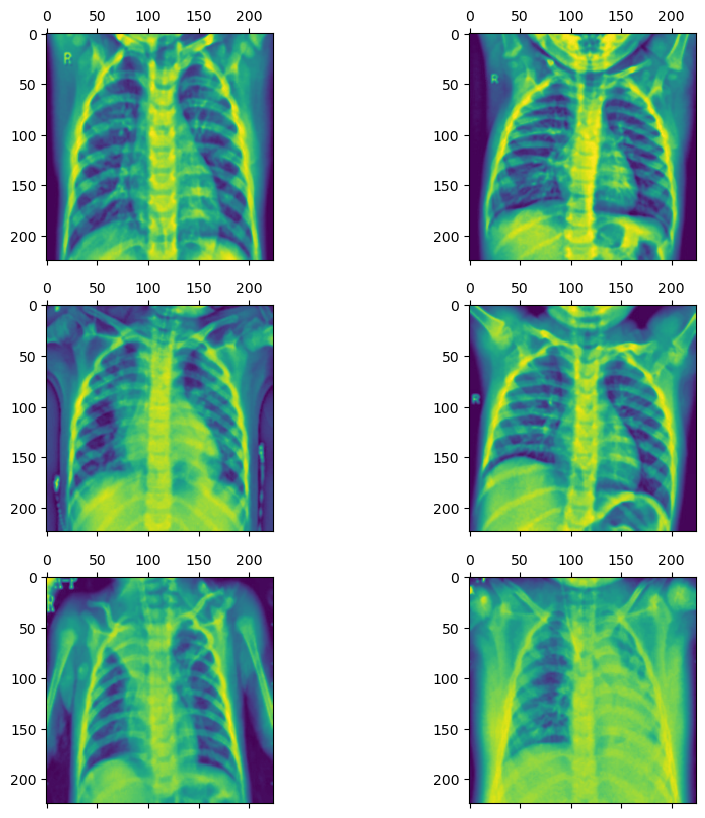

In [17]:
#Pneumonia
plot_image = plt.figure(figsize=(10,10))

plot1 = plot_image.add_subplot(3,2,1)
plot2 = plot_image.add_subplot(3,2,2)
plot3 = plot_image.add_subplot(3,2,3)
plot4 = plot_image.add_subplot(3,2,4)
plot5 = plot_image.add_subplot(3,2,5)
plot6 = plot_image.add_subplot(3,2,6)
plot1.matshow(plt.imread(train_generator.filepaths[41]))
plot2.matshow(plt.imread(train_generator.filepaths[176]))
plot3.matshow(plt.imread(train_generator.filepaths[1553]))
plot4.matshow(plt.imread(train_generator.filepaths[354]))
plot5.matshow(plt.imread(train_generator.filepaths[2679]))
plot6.matshow(plt.imread(train_generator.filepaths[2710]))

**Plotting the images with normal condition from the dataset**

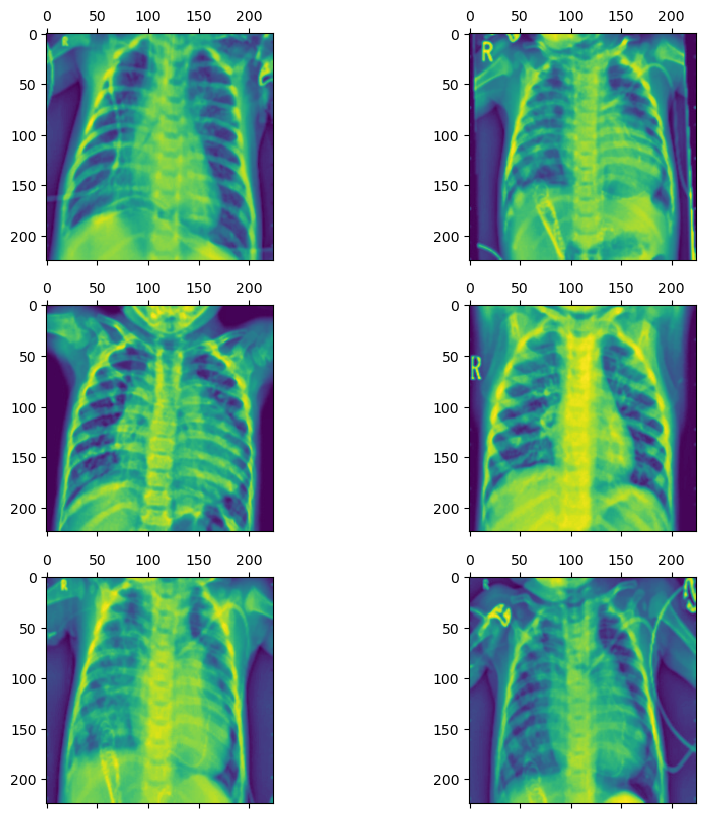

In [19]:
#Normal
plot_image = plt.figure(figsize=(10,10))

plot1 = plot_image.add_subplot(3,2,1)
plot2 = plot_image.add_subplot(3,2,2)
plot3 = plot_image.add_subplot(3,2,3)
plot4 = plot_image.add_subplot(3,2,4)
plot5 = plot_image.add_subplot(3,2,5)
plot6 = plot_image.add_subplot(3,2,6)
plot1.matshow(plt.imread(train_generator.filepaths[1419]))
plot2.matshow(plt.imread(train_generator.filepaths[1365]))
plot3.matshow(plt.imread(train_generator.filepaths[1400]))
plot4.matshow(plt.imread(train_generator.filepaths[1350]))
plot5.matshow(plt.imread(train_generator.filepaths[1345]))
plot6.matshow(plt.imread(train_generator.filepaths[1349]))

# Convolutional Neural Network (CNN)<br>
CNN consists of convolutional layers and pooling layers. ANN consists of hidden layers and output layers.<br>
To develop the model i have used 5 **Conv2d** layers which are followed by maxpooling layers for every **Conv2d** layers.<br>
Then for classification ANN with 2 hidden layers and one output layer which has a single neuron is used.<br><br>

**Activation Function:** <br><br>
ReLU is used in the hidden layers and Conv2D layers.<br>
Sigmoid is used because the output we need is binary classification.<br>
**Loss Function:** Binary cross entropy is used.<br>
**Optimizer:** Adam optimizer is used because it gives best result.

In [21]:
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Conv2D(16, (3,3), activation= 'relu', input_shape= (300, 300, 3)),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(32, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),

                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(256, activation= 'relu'),
                                   tf.keras.layers.Dense(512, activation= 'relu'),
                                   tf.keras.layers.Dense(1, activation= 'sigmoid')
])
model.summary()
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,983,009 (7.56 MB)

 Trainable params: 1,983,009 (7.56 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator)

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 415s 11s/step - accuracy: 0.7304 - loss: 0.6544 - val_accuracy: 0.7312 - val_loss: 0.6013
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 243s 7s/step - accuracy: 0.7323 - loss: 0.5634 - val_accuracy: 0.7979 - val_loss: 0.3978
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - accuracy: 0.8635 - loss: 0.3159 - val_accuracy: 0.8870 - val_loss: 0.2529
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.8702 - loss: 0.2914 - val_accuracy: 0.9058 - val_loss: 0.2217
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.9034 - loss: 0.2395 - val_accuracy: 0.9058 - val_loss: 0.2233
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - accuracy: 0.9185 - loss: 0.2067 - val_accuracy: 0.9041 - val_loss: 0.2406
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/step - accuracy: 0.9148 - loss: 0.2157 - val_accuracy: 0.9298 - val_loss: 0.1728
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - accuracy: 0.9318 - loss: 0.1749 - val_accuracy: 0.9229 - 

**Accuracy: 97.72%** <br>
**Validation Accuracy: 95.55%**

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

**Plotting Loss vs. Number of Epochs**

Loss Vs Num. of Epochs
Training Loss : 0.0519 
Value loss : 0.0701


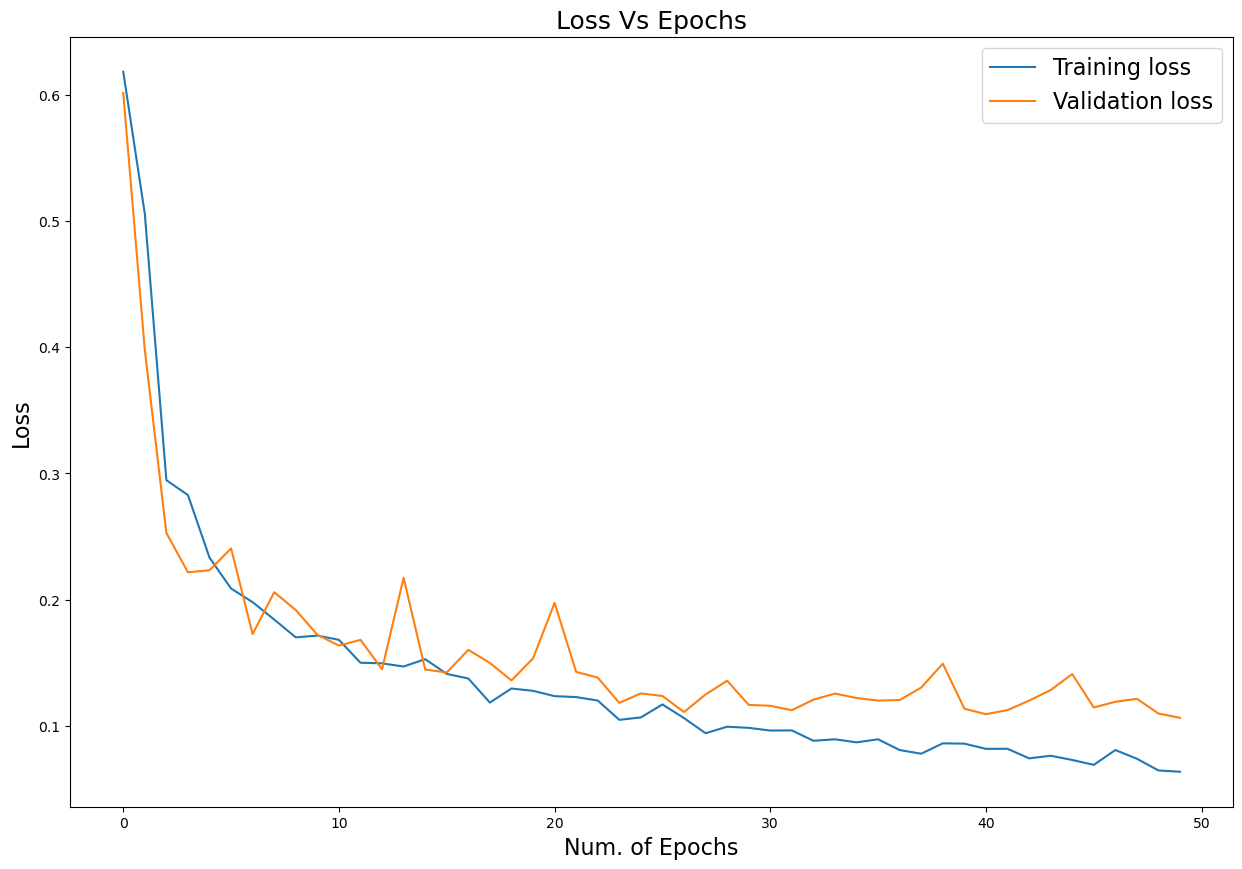

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'], fontsize=16)
plt.title("Loss Vs Epochs", fontsize=18)
plt.xlabel("Num. of Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
print("Loss Vs Num. of Epochs")
print("Training Loss : 0.0519","\nValue loss : 0.0701")
plt.show()

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

**Plotting Accuracy Vs Num. of Epochs**

Accuracy Vs Epochs
Training accuracy : 0.9816 
Value accuracy : 1.0000


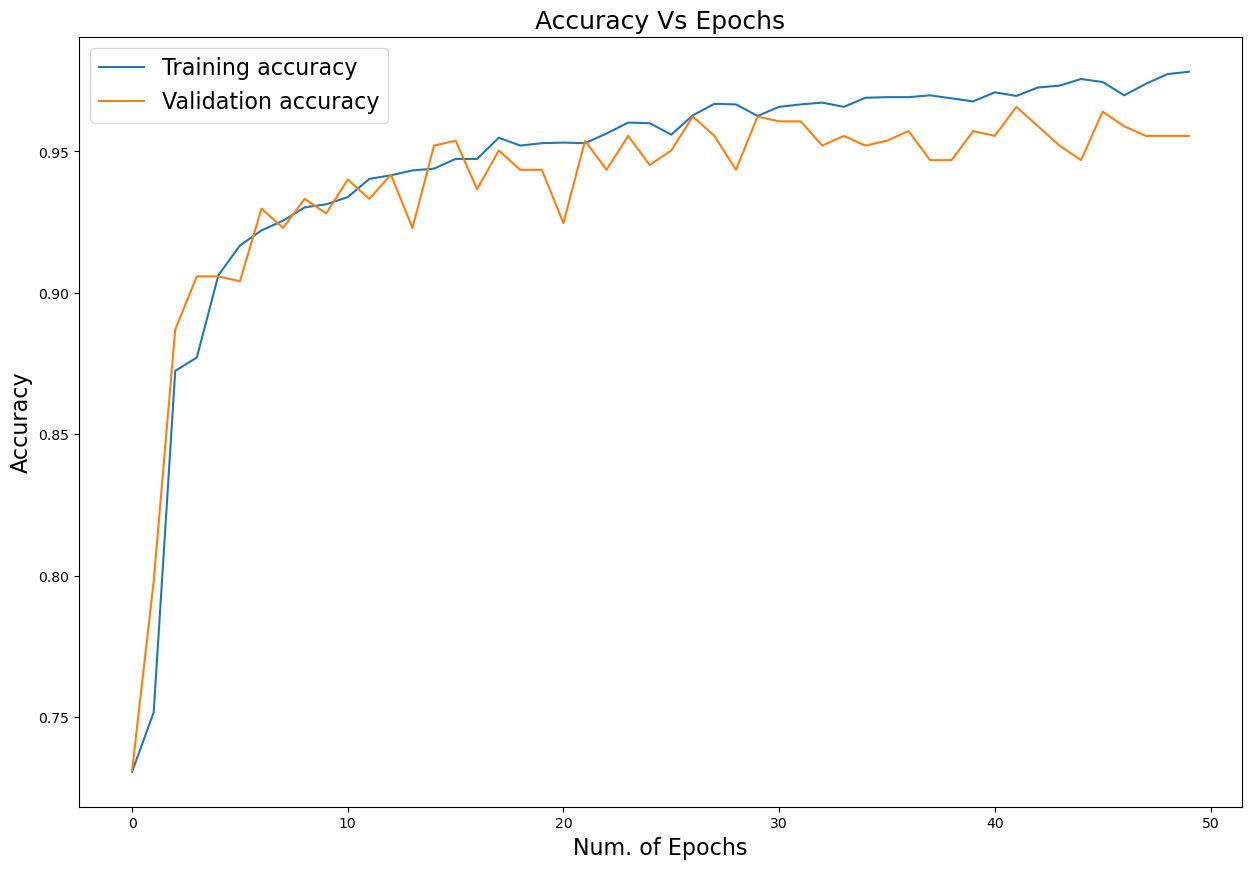

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['Training accuracy','Validation accuracy'], fontsize=16)
plt.title("Accuracy Vs Epochs", fontsize=18)
plt.xlabel("Num. of Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
print("Accuracy Vs Epochs")
print("Training accuracy : 0.9816","\nValue accuracy : 1.0000")
plt.show()

**Saving the model for further uses**

In [33]:
model.save("trained.h5")

**Loading the saved model so that we can further use it for deployment in the web application and it will save lots of time**

In [35]:
from keras.models import load_model
model = load_model("trained.h5")

**Loading the test data to evaluate the performance**

In [45]:
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    'images_001/split_data/test',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model.evaluate(test_generator, steps=624)
print('loss :', eval_result[0])
print('accuracy :', eval_result[1])

Found 584 images belonging to 2 classes.
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9538 - loss: 0.0973    
loss : 0.09739106148481369
accuracy : 0.9537671208381653


In [49]:
img= cv2.imread('images_001/split_data/test/NORMAL/IM-0029-0001.jpeg')
tempimg = img
img = cv2.resize(img,(300,300))
img = img/255.0
img = img.reshape(1,300,300,3)
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


array([[0.00154289]], dtype=float32)

**A random image is selected and tested to analyze the prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: Normal


Text(0.5, 1.0, 'Prediction: Normal')

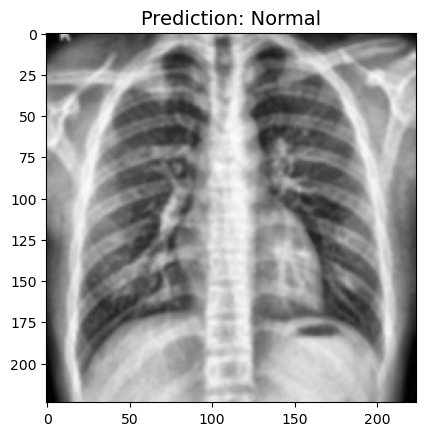

In [51]:
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)

In [53]:
img= cv2.imread('images_001/split_data/test/PNEUMONIA/person100_bacteria_480.jpeg')
tempimg = img
img = cv2.resize(img,(300,300))
img = img/255.0
img = img.reshape(1,300,300,3)
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


array([[0.99999297]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Pneumonia


Text(0.5, 1.0, 'Prediction: Pneumonia')

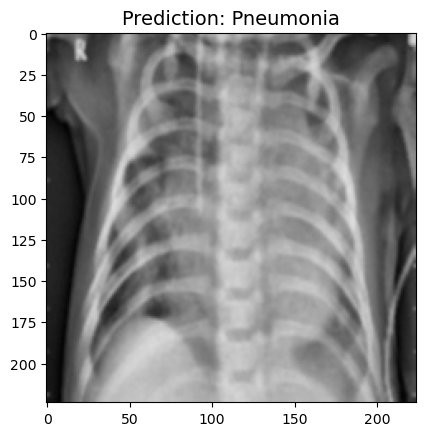

In [55]:
prediction = model.predict(img) >= 0.5
if prediction>=0.5:
  prediction = "Pneumonia"
else:
  prediction = "Normal"
print("Prediction: "+prediction)
plt.imshow(tempimg)
plt.title("Prediction: "+prediction, fontsize=14)